In [63]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

## Original measurements from assessment 1
#X = [1, 1.6, 2.9, 1.3, 1.3, 2.4, 2.5, 1.9, 1.3, 2.3]
#X = [0 - x for x in X]
#Y = [1.1, 1.2, 3.1, 2.1, 1.5, 3.2, 3.6, 2.3, 1.4, 2.9]

# measurements for move by 40cm
A = [39.7, 39.8, 39.9, 39.8, 39.9, 39.85, 39.8, 39.95, 39.85, 39.98]
B = [0.5, 0.45, 0.2, 0.07, -0.02, -0.02, 0.2, 0.25, 0.35, 0.55]

A = [a / np.mean(A) * 40 for a in A] # normalize the values as they should be calibrated in the current design


# most recent measurements for end point
X = [-0.8, -0.7, -0.3, -0.15, 0.15, 0.25, 0.3, 0.4, 1.2, 0.1]
Y = [-0.5, 0.05, 0.1, -0.12, -0.2, 0.07, 0.3, -0.37, 0.55, 0.8]

x_target = np.mean(X)
y_target = np.mean(Y)

R = 16 # distance between centers of motors
r = 40 * 2 / (np.pi * R)

def displace(curr, distance, angle):
    """
    Note: angle should be in radians
    Given a pose (x, y, angle) and a desired transformation, returns the new pose
    
    Parameters:
    curr (float, float, float): position of the robot with reference to the starting position (x, y, angle)
    distance (float): distance by which to move
    angle (float): angle by which rotate
    
    returns (float, float, angle): new x,y, angle position
    """
    
    R = [[np.cos(angle), -np.sin(angle), distance], [np.sin(angle), np.cos(angle), 0], [0, 0, 1]]
    
    return np.append(np.matmul(R, [curr[0], curr[1], 1])[:2], curr[2] + angle)

def displace_with_noise(curr, distance, angle, e, f, g):
    """
    Note: angle should be in radians
    Given a pose (x, y, angle) and a desired transformation, returns the new pose with added random noise.
    Note that it does the rotation first, then the forward movement.
    Can be used to generate particle distribution. The way it would be used in code would be f.e.:
    
    def move(distance, particles):
        start = get_motor_encoder
        target = target_encoder_position
        while(enc != target):
            curr = get_motor_encoder
            d = (curr - start) / (target - start)
            curr_particles = [displace_with_noise(p, d * distance, 0, e / d, f / d, g / d) for p in particles]
            display(curr_particles)
        for in range(len(particles)):
            particles[i] = curr_particles[i]
    
    Parameters:
    curr (float, float, float): position of the robot with reference to the starting position (x, y, angle)
    distance (float): distance by which to move
    angle (float): angle by which rotate
    
    returns (float, float, angle): new x,y, angle position
    """
    
    res = curr.copy()
    res[2] = res[2] + angle + random.gauss(0, g)
    res[0] = res[0] + (distance + random.gauss(0, e)) * np.cos(res[2])
    res[1] = res[1] + (distance + random.gauss(0, e)) * np.cos(res[2])
    res[2] = res[2] + random.gauss(0, f)
    
    return res


def move(particles, distance, history, e, f):
    for p in particles:
        p[0] = p[0] + (distance + random.gauss(0, e)) * np.cos(p[2])
        p[1] = p[1] + (distance + random.gauss(0, e)) * np.sin(p[2])
        p[2] = p[2] + random.gauss(0, f)
    new_particles = [p.copy() for p in particles]
    plt.scatter(np.array(particles)[:,0], np.array(particles)[:,1])
    history.extend(new_particles)
    
def rotate(particles, angle, history, g):
    for p in particles:
        p[0] = p[0]
        p[1] = p[1]
        p[2] = p[2] + angle + random.gauss(0, g)
    new_particles = [p.copy() for p in particles]
    history.extend(new_particles)

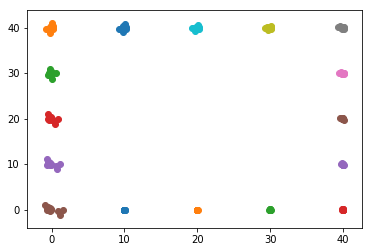

In [64]:
e = stats.sem(X) ** 2
f = stats.sem(B) ** 2
g = 0.01 # more or less half angle, could be calibrated by measuring the angle variance on a 360 rotation
NUMBER_OF_PARTICLES = 11
history = []
particles = [[0, 0, 0] for _ in range(NUMBER_OF_PARTICLES)]
for _ in range(4):
    for _ in range(4):
        move(particles, 10, history, e, f)
    rotate(particles, np.pi / 2, history, g)

0.045000000000000005 0.047982607938088
0.06800000000000002 0.013778254788358459
0.18279466318492146 0.25115586534988216
0.12670876493404515 0.17508075946193621


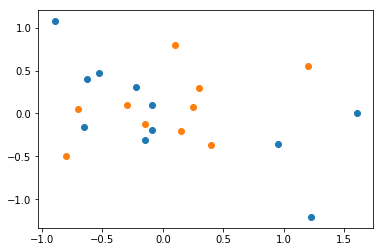

In [65]:
history = np.array(history)
plt.show()
print(np.mean(X), np.mean(history[-NUMBER_OF_PARTICLES:, 0]))
print(np.mean(Y), np.mean(history[-NUMBER_OF_PARTICLES:, 1]))
print(stats.sem(X), stats.sem(history[-NUMBER_OF_PARTICLES:, 0]))
print(stats.sem(Y), stats.sem(history[-NUMBER_OF_PARTICLES:, 1]))

plt.scatter(history[-NUMBER_OF_PARTICLES:, 0], history[-NUMBER_OF_PARTICLES:, 1])
plt.scatter(X, Y)
plt.show()